### IMPORTS

In [1]:
from Inference.VariationalAE2 import MeanFieldVariationalAE
from Inference.Variational import MeanFieldVariationalDistribution

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [5]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

# Load data #

In [6]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [7]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

# Model principal

In [8]:
model = nn.Sequential( nn.Linear(1,20),
                       nn.Tanh(),               
                       nn.Linear(20,1),
                     ).to(device)
for params in model.parameters():
    params.requires_grad = False

In [9]:
param_count = get_param(model).shape[0]
param_count

61

In [10]:
flip_parameters_to_tensors(model)

# Calcul du posterior sur les paramètres principaux #

À chaque paramètre $\theta\in \mathbb{R}^{61}$ correspond un prédicteur $f_\theta:\mathbb{R}\to \mathbb{R}$. Le postérieur sur les paramètres principaux est défini comme:
$$
P(\theta | \text{data})=P(\theta)P(\text{data}|\theta)
$$
où $P(\theta)$ est un prior $N(0,I)$ et le likelihood est donné par
$$
P(\text{data}|\theta)=\prod_{(x,y)\in\text{data}}P(y|f_\theta(x),0.1)
$$
où $P(y|f_\theta(x),\sigma)$ la fonction de densité de la loi normale de moyenne $f_\theta(x)$ et d'écart-type $0.1$ (qui correspond au bruit utilisé pour générer les données).

In [11]:
#Prior
prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(param_count),torch.eye(param_count))

def logprior(theta):
    return prior.log_prob(theta)

In [12]:
def log_norm(y,y_,std):
    point_estimate= torch.distributions.normal.Normal(y_, std)
    return point_estimate.log_prob(y)

In [13]:
# likelihood of the parameters

def loglikelihood(theta):
    set_all_parameters(model, theta)
    y_pred = model(x_data)
    L = log_norm(y_pred, y_data, torch.tensor([0.1]))
    return torch.sum(L).unsqueeze(-1)


In [14]:
#Temperature
T=1
#log posterior
def logposterior(theta):
    return 1/T*logprior(theta).add(loglikelihood(theta))


# Modèle génératif: Hypernet autoencodeur

In [16]:
#choisir la dimension pour les paramètres latents
# lat_dim=5 donne des résultats intéressants!
lat_dim=5
nb_mid=61

In [17]:
# initialise 
# – (encodeur) une gaussienne diagonale N(0,sigma*I): mfvar ("dummy" prior sur les variables latentes)
# – (decodeur) un NN avec 1 layer param_count neurones, activtion nn.Tanh()/nn.ReLU(): decoder
# forward(n): échantilloner theta=mfvar.decoder(mfvar.sample(n))
sigma_p=1.
VAE = MeanFieldVariationalAE(lat_dim,nb_mid,nb_mid,param_count,extraLayer=False,activation=nn.ReLU(),sigma=sigma_p)
print('nb de paramètres VAE:'+str(get_param(VAE).shape[0]))
VAE


nb de paramètres VAE:4158


MeanFieldVariationalAE(
  (mfvar): MeanFieldVariationalDistribution()
  (layerIn): Linear(in_features=5, out_features=61, bias=True)
  (layerOut): Linear(in_features=61, out_features=61, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=61, bias=True)
    (1): ReLU()
    (2): Linear(in_features=61, out_features=61, bias=True)
  )
)

In [2]:
def init_weightsIn(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,)
        #torch.nn.init.normal_(m.weight,mean=0., std=.01)
        m.bias.data.fill_(0.00)
        
def init_weightsOut(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0., std=.4)
        m.bias.data.fill_(0.)
        
#VAE.layerIn.apply(init_weightsIn)
VAE.layerOut.apply(init_weightsOut)

NameError: name 'VAE' is not defined

# Visualisation de l'initialisation #

<IPython.core.display.Javascript object>


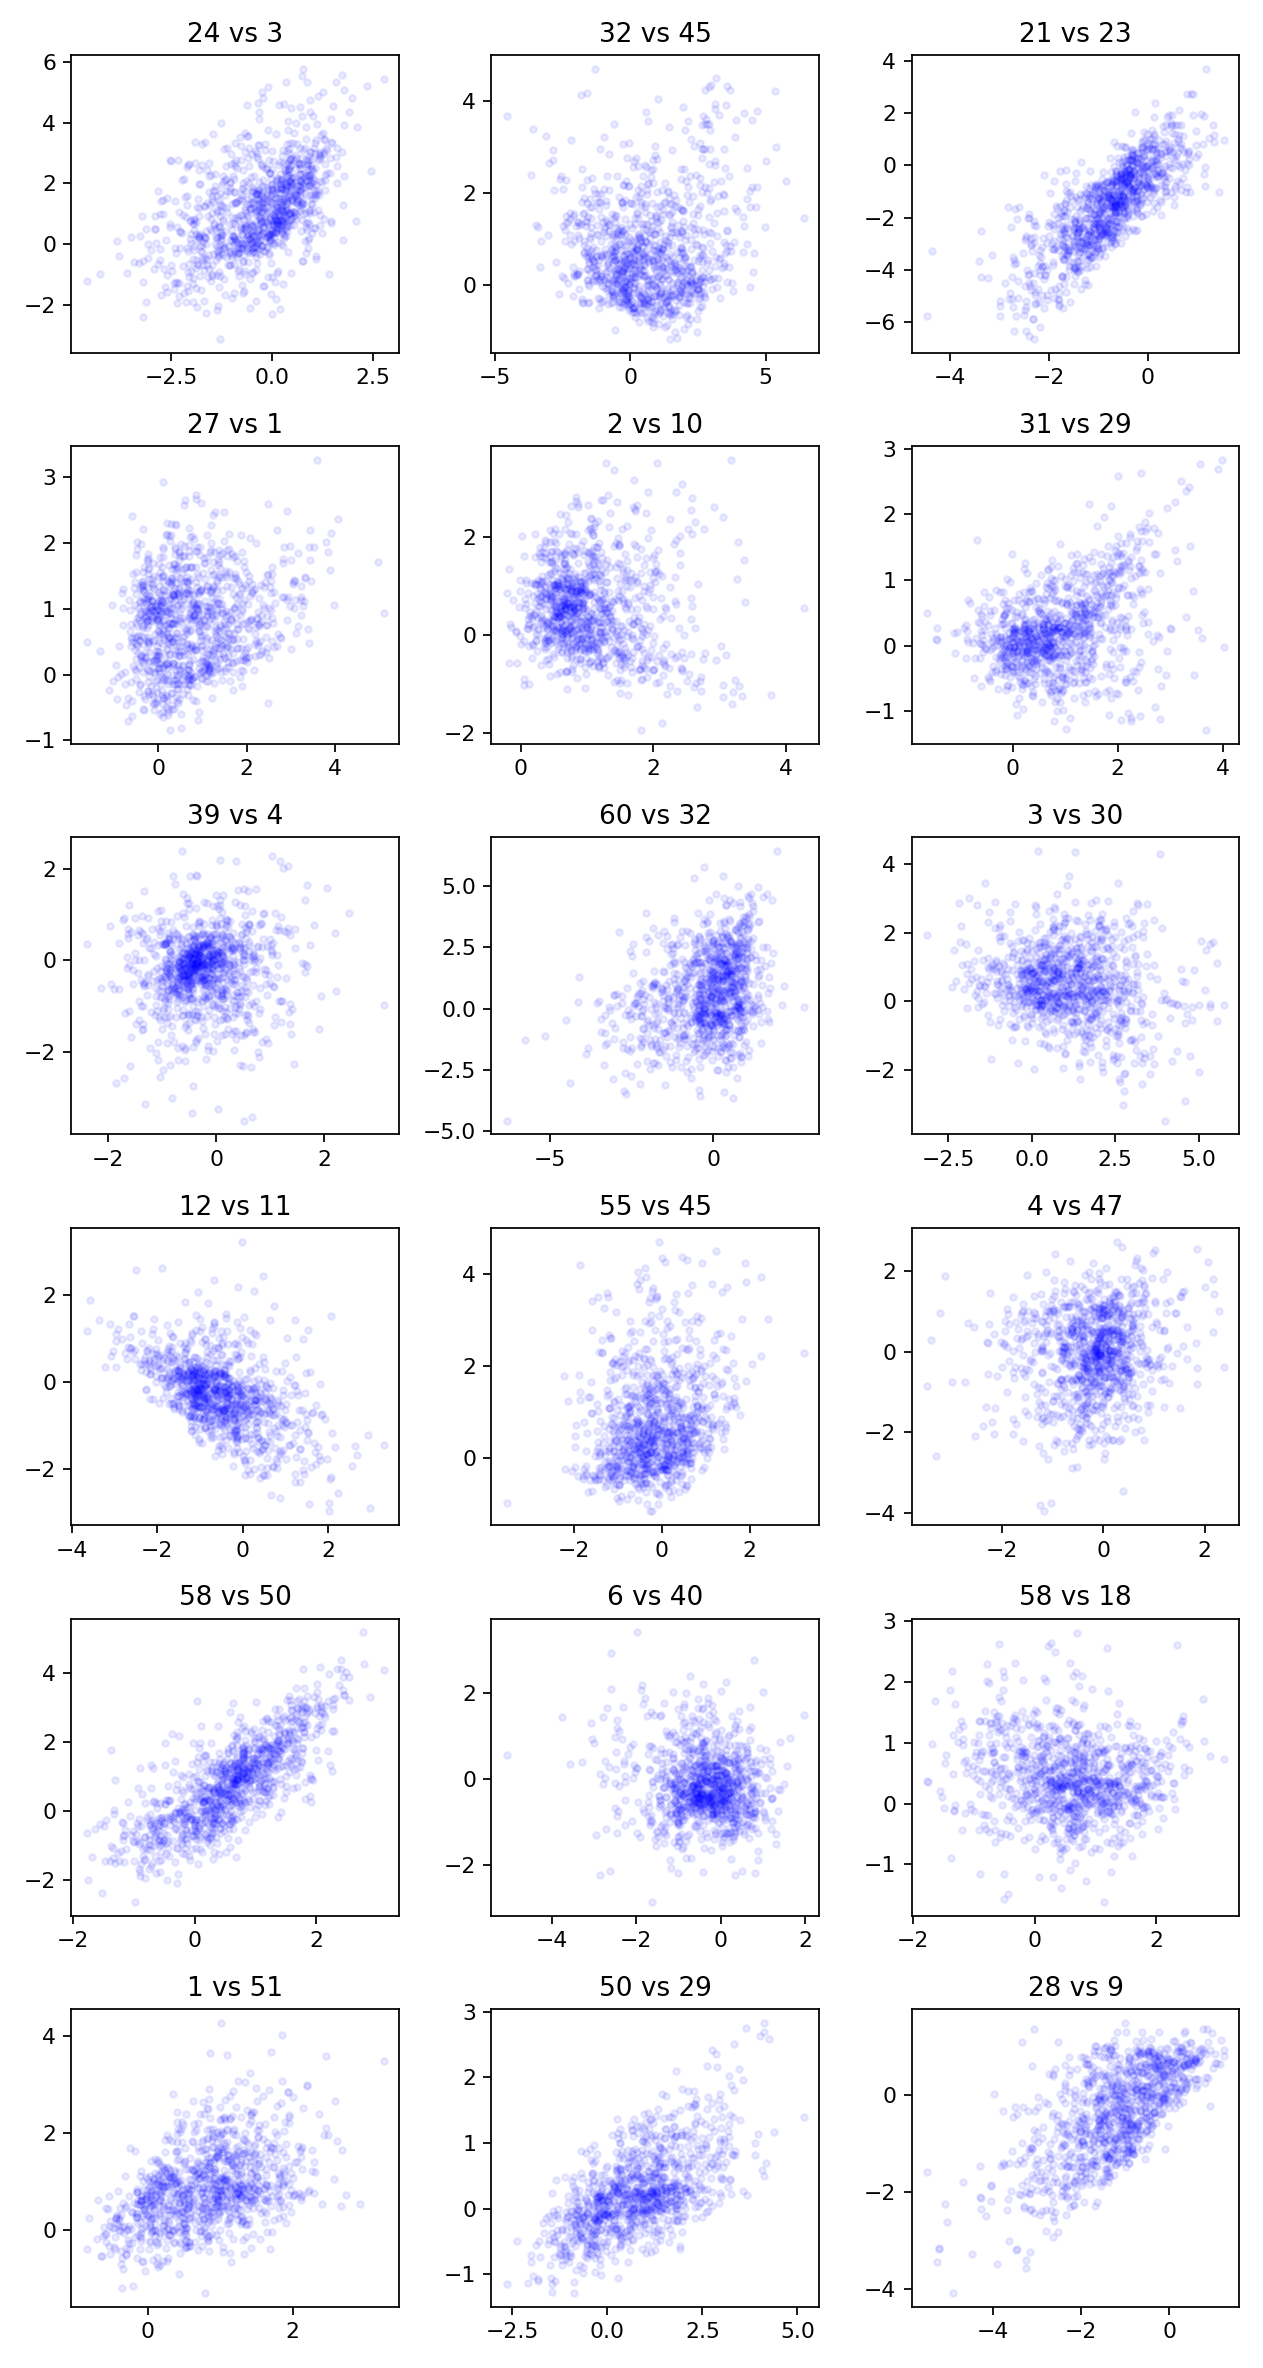

In [19]:
# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters

import matplotlib.pyplot as plt
%matplotlib notebook

theta = VAE(1000).detach().numpy()

fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(theta[:,i[0]],theta[:,i[1]],marker='.',alpha=0.08,color='blue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

<IPython.core.display.Javascript object>


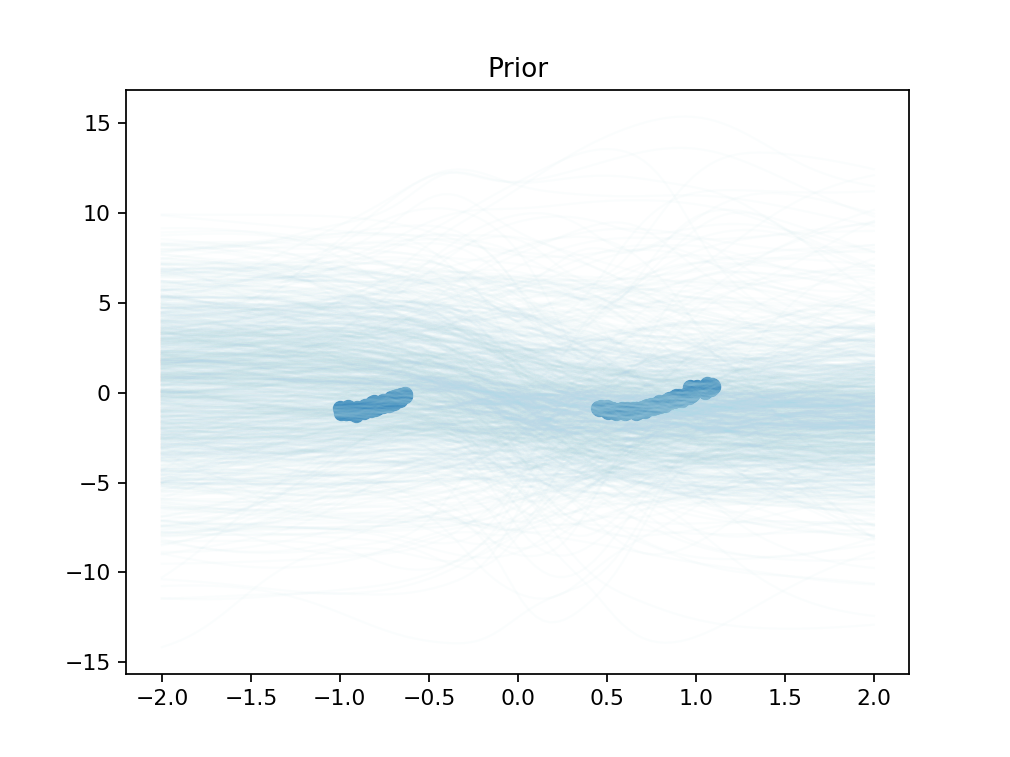

In [20]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
import math

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.title('Prior')


plt.scatter(x_data.cpu(), y_data.cpu())
for i in range(1000):
    theta = VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')


# Training #

Le posterior $P(\theta)=P(\theta|\text{data})$ sur les paramètres $\theta$ du modèle principal est non normalisé. C'est l'input de la méthode VAE. Le paramètre principal du VAE est une fonction $g:\mathcal{Z}\to \Theta$ de l'espace des variables latentes vers l'espace des variables principales. Notons $Z$ une variable aléatoire à valeur dans $\mathcal{Z}$ de loi normale diagonale $N(0,I)$. Considérons la variable aléatoire $Y=g(Z)$. La fonction maximisée durant l'entraînement du VAE est une borne inférieure de l'espérance:
$$
E(g)=E[P(Y)]=\int P(g(z))\tilde{P}(z) dz
$$
où $\tilde{P}(z)$ est la fonction de densité de $Z$.

La valeur maximale $E_\max$ de cette espérance est atteinte pour une fonction constante $g(z)=\theta_\text{map}$ où $P(\theta_\text{map})=\max_\theta P(\theta)$ si ce maximum existe. Cependant le maximum a posteriori peut très bien ne pas être unique et il se peut même que le postérieur $P$ atteigne son maximum sur une sous-variété de l'espace des paramètres. Plus précisément, pour tout $\epsilon>0$, notons
$$
\text{MAP}_\epsilon=\bigl\{\theta \mid P(\theta)+\epsilon>P(\theta_\text{map})\bigr\}
$$
l'ensemble des paramètres $\theta$ qui sont des $\epsilon$-map. Alors pour toute transformation $g$ telle que le support de la fonction de densité de $Y=g(Z)$ est contenu dans $\text{MAP}_\epsilon$ pour un $\epsilon$ suffisament petit on aura $E(g)\approx E_\max$. 

Nous pouvons seulement échantilloner la distribution VAE, c'est la fonction forward de VAE: on échantillonne z selon VAE.mfvar.sample() puis on applique le decoder theta=VAE.decoder(z). La fonction de densité du VAE n'est pas disponible.

Notons le decodeur $g_{\lambda}:\mathcal{Z}\to \Theta$ pour simplifier la notation et mettre en évidence les paramètres qui le caracérise.

On définit pour tout $\lambda$ une distribution de probabilité sur les variables latentes par:
$$
P_\lambda(z)=\frac{P(z)P(g_{\lambda}(z))}{E_\lambda}.
$$
où $P(z)\sim N(0,I)$ est un "dummy" prior sur les variables latentes, la PDF de la variable aléatoire $Z$, et la constante de normalisation est donnée par:
$$
E(g_\lambda)=E_\lambda=\int P(g_\lambda(z))P(z)dz,
$$
c'est la quantité à optimiser.

Si $Q(z)$ est une distribution quelconque sur $z$, alors:
$$
D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z) )=D_\text{KL}(Q(z)\mathbin{\Vert} P(z)) - E_{Q(z)}[\log P(g_\lambda(z)]+ \log E_\lambda.
$$
Donc pour tout $\lambda$:
$$
\log E_\lambda\geq \log E_\lambda-D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z))= -D_\text{KL}(Q(z)\mathbin{\Vert} P(z)) + E_{Q(z)}[\log P(g_\lambda(z)]=\text{ELBO}(Q,\lambda)
$$

Le but est alors de trouver une distribution $Q$ qui maximise le terme de droite. Cet objectif maximise la différence entre la log-evidence $\log E_\lambda$ et la divergence entre $Q(z)$ et la distribution $P_\lambda(z)$. 

On se restricte alors aux distributionx normales diagonales $Q(z|\mu,\sigma)\sim N(z; \mu, \text{diag}(\sigma))$. On se propose de minimiser la fonction:
$$
-\text{ELBO}(\mu,\sigma,\lambda)=D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z))-\log E_\lambda=D_\text{KL}(Q(z|\mu,\sigma)\mathbin{\Vert} P(z))- E_{Q(z)}[\log P(g_\lambda(z))]
$$

Si $D_\text{KL}(Q(z|\mu,\sigma) \mathbin{\Vert} P(z))$ peut être calculée en dollars et ne dépend pas de $\lambda$, le terme $E_{Q(z)}[\log P_\lambda(\text{data}|z)]$ est estimé en échantillonant des $z_i$ puis en faisant la moyenne des $\log P_\lambda(z_i)$.

À noter que si $g_\lambda(z)=\theta_c$ est constante alors 
$$
P_\lambda(z)=\frac{P(z)P(\theta_c)}{E_\lambda}=P(z),
$$
puisque $E_\lambda=\int P(z)P(\theta_c)dz=P(\theta_c)$. Ainsi si $g_\lambda=\theta_c$ est constante, alors l'évidence est égale $P(\theta_c)$. De plus pour $Q(z|\mu,\sigma)=P(z)$ on que 
$$
\log P(\theta_c)\geq \text{ELBO}(\mu,\sigma,\lambda)=\log P(\theta_c)-D_\text{KL}(P(z)\mathbin{\Vert} P(z)) =\log P(\theta_c).
$$
Par conséquent, si $g_\lambda(\theta)=\theta_\text{MAP}$ et $Q(z)=P(z)$ alors l'évidence est maximale et la ELBO est égale à l'évidence.   


In [21]:
def log_norm_mv(theta1,theta2,H):
    mvn = torch.distributions.multivariate_normal.MultivariateNormal(theta1,H*torch.eye(param_count))
    return mvn.log_prob(theta2)


In [22]:
VAE_optimizer = torch.optim.Adam(VAE.parameters(), lr=.1)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=60, factor=0.5)
%matplotlib inline
liveloss = PlotLosses()

In [23]:

H=.5 #Kernel Density Estimation hyper-parameter 
n_samples_VAR = 200
n_samples_ED=10

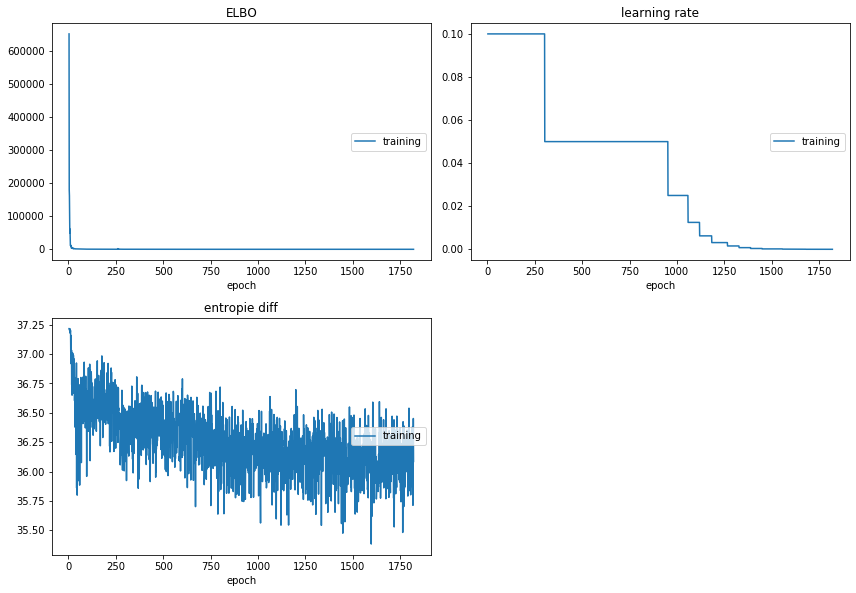

ELBO:
training   (min: -101.079, max: 1293749.250, cur:  -95.723)

learning rate:
training   (min:    0.000, max:    0.100, cur:    0.000)

entropie diff:
training   (min:   35.383, max:   37.217, cur:   36.086)


In [27]:
%matplotlib inline
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    learning_rate = VAE_optimizer.param_groups[0]['lr']
    

    LP=torch.Tensor(n_samples_VAR)
    for i in range(n_samples_VAR):
        theta=VAE()
        LP[i]=logposterior(theta)
    
    LQ=torch.Tensor(n_samples_ED,n_samples_ED)
    theta_ED=VAE(n_samples_ED)
    for i in range(n_samples_ED):
        for j in range(i+1):
            LQ[i,j]=LQ[j,i]=log_norm_mv(theta_ED[i],theta_ED[j],H)      
    ED=LQ.logsumexp(0)-torch.log(torch.Tensor([n_samples_ED]))    
    
    L = 1.*ED.mean() - LP.mean()

    L.backward()
    

    

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.mean().detach().clone().cpu().numpy()
#    logs['predictive likelihood'] = LL.mean().detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 20 == 0:
        x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
        fig, ax = plt.subplots()
        fig.set_size_inches(6, 6)

        plt.scatter(x_data.cpu(), y_data.cpu())
        for i in range(1000):
            theta = VAE().detach()
            set_all_parameters(model, theta)
            y_test = model(x_test)
            plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

    
    
    if t % 5 == 0:
        liveloss.draw()

    VAE_optimizer.step()

    if learning_rate < 0.00001:
        break

# Résultats #

In [32]:
(-ED.mean(),LP.mean())

(tensor(35.8765, grad_fn=<NegBackward>),
 tensor(57.6788, grad_fn=<MeanBackward0>))

<IPython.core.display.Javascript object>


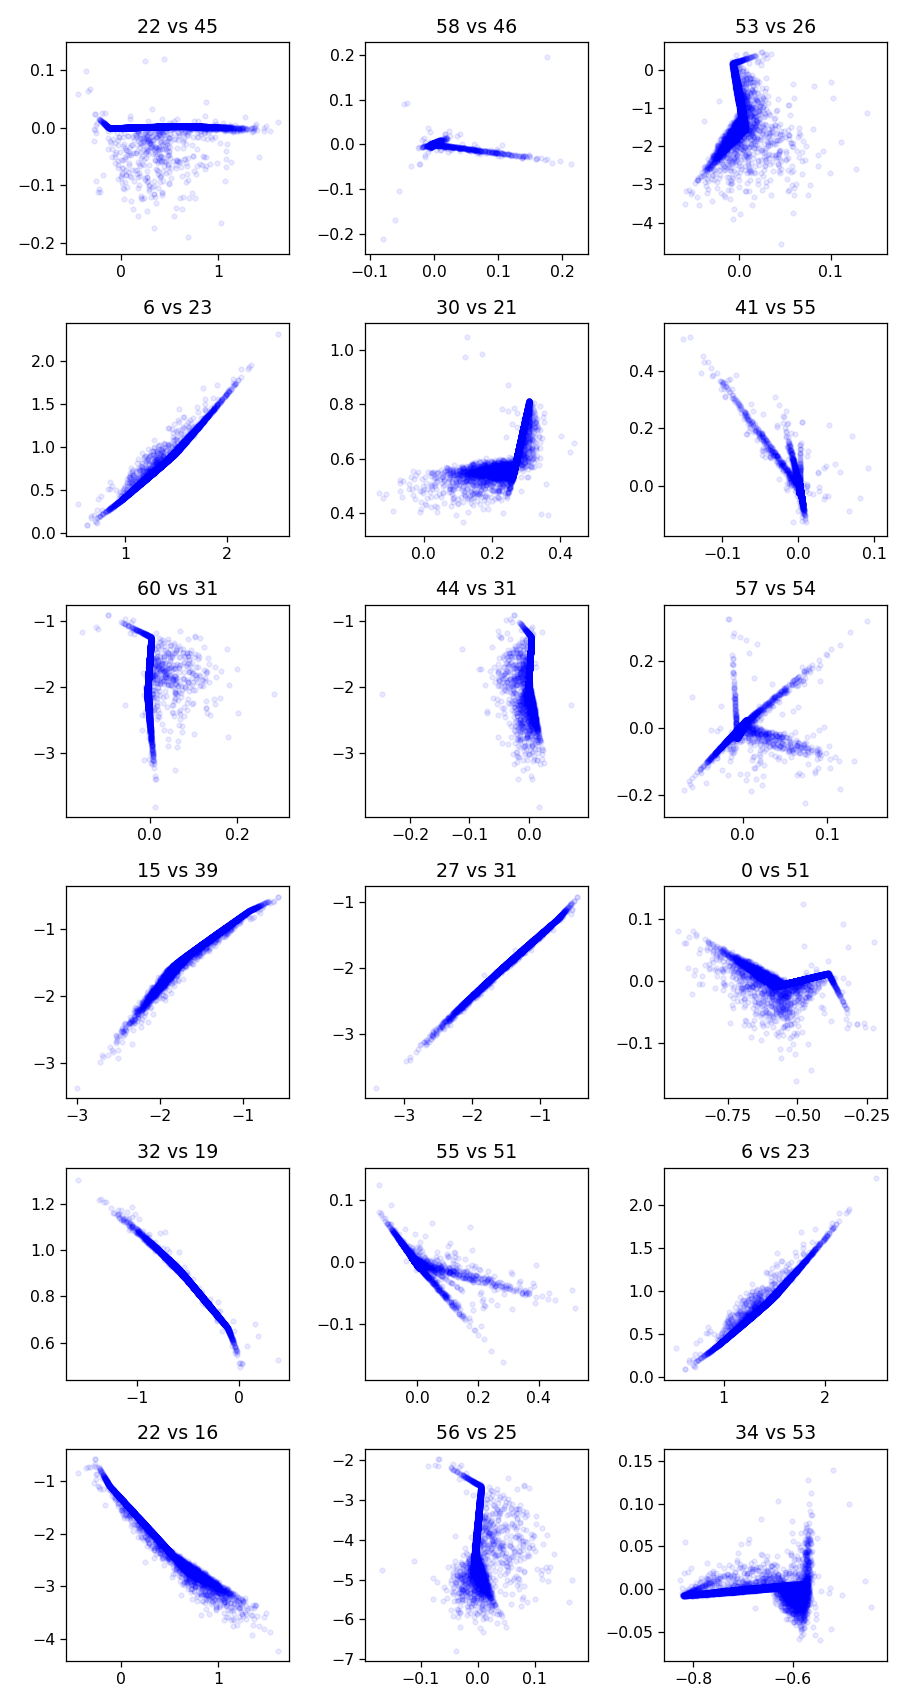

In [30]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook

# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters


L = VAE(10000).detach().numpy()


fig, axs = plt.subplots(6, 3,figsize=(8,15))
for k in range(6):
    for l in range(3):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.08,color='blue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

## Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution ##


<IPython.core.display.Javascript object>


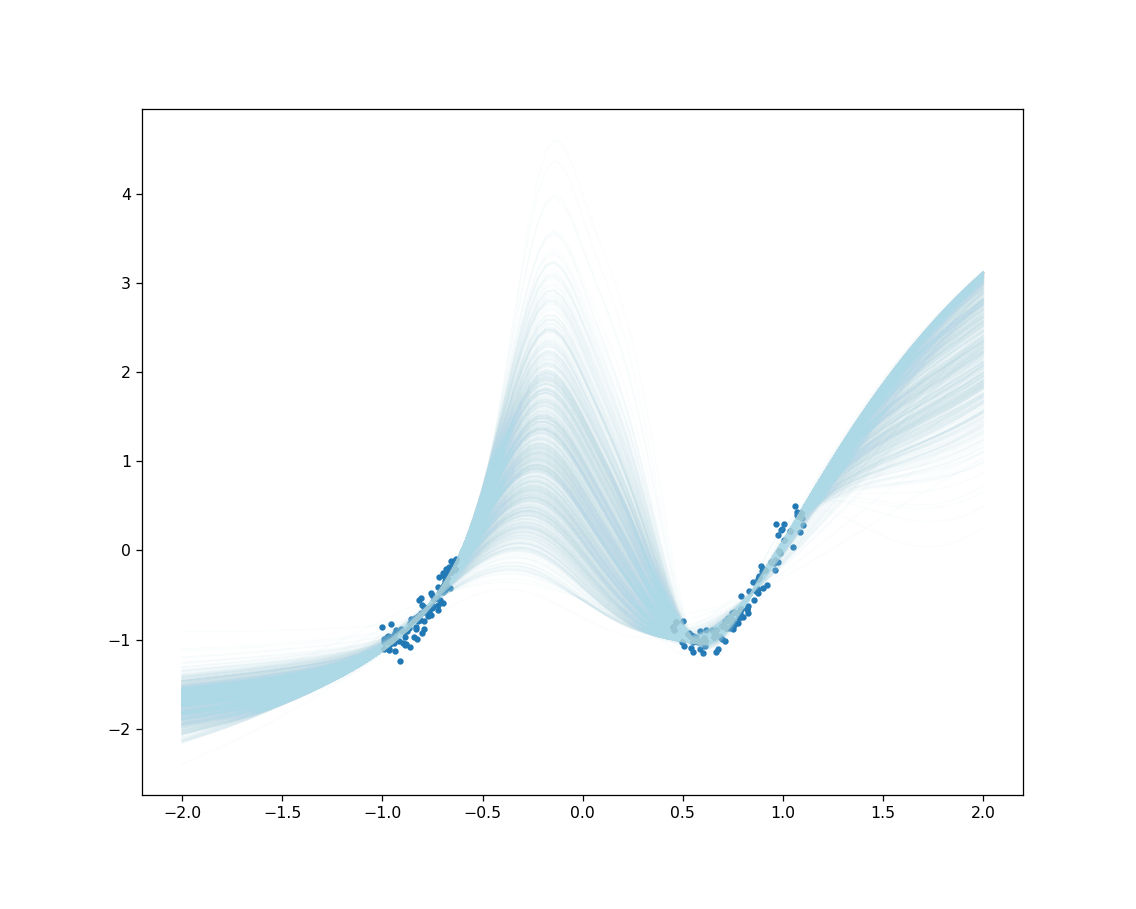

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook


x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
for i in range(1000):
    theta=VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')



In [105]:
# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt


L = VAE(10000).detach()
P=torch.Tensor(10000,1)

for i in range(10000):
    P[i]=logposterior(L[i].unsqueeze(0))

print((P.mean(),P.std()))


(tensor(37.2269), tensor(92.1520))


<IPython.core.display.Javascript object>


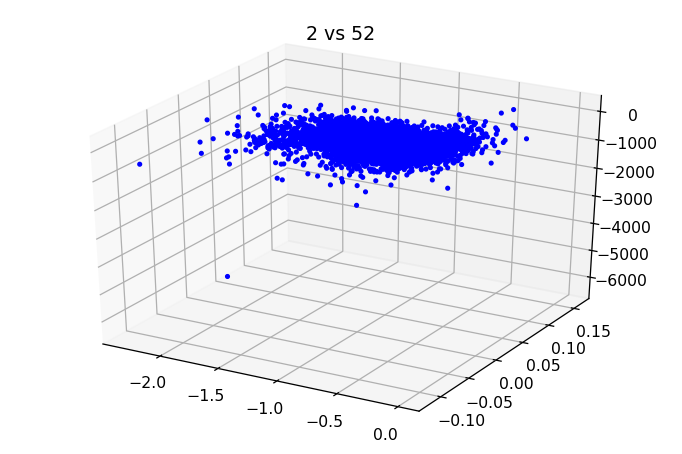

In [113]:
%matplotlib notebook

fig = plt.figure()

for k in range(1):
    for l in range(1):
        k_=k+1
        l_=l+1
        ax = fig.add_subplot(k_,1,l_, projection='3d')
        i=(2,52)#np.random.choice(a=np.arange(param_count), size=2,replace=False)
        ax.scatter(L[:,i[0]],L[:,i[1]],P, marker='.',alpha=1.,color='blue')
        ax.set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()